在决策树学习中，为了尽可能正确地分类训练样本，节点划分过程将不断重复，有时会造成决策树分支过多，从而导致过拟合。譬如下面这样的例子，通过 sklearn 的 `datasets.make_moons` 生成的样本：

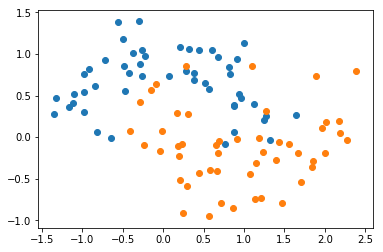

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets

X, y = datasets.make_moons(noise=0.25, random_state=666)

plt.scatter(X[y==0, 0], X[y==0, 1])
plt.scatter(X[y==1, 0], X[y==1, 1])
plt.show()

我们使用不带任何限制的决策树对样本进行分类，可以看到为了让决策树的每个节点包含的样本纯度达到最高，最极端的情况就是每个节点只包含一个类别。虽然这样对样本数据的分类准确度非常高，但这是典型的过拟合情况，模型的泛化能力非常差。

/home/aneasystone/anaconda3/lib/python3.7/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'linewidth'
  s)


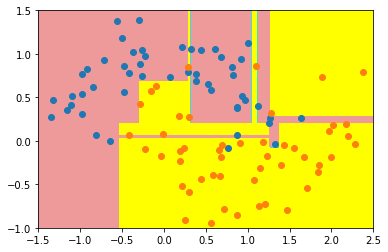

In [3]:
from sklearn.tree import DecisionTreeClassifier

dt_clf = DecisionTreeClassifier()
dt_clf.fit(X, y)

def plot_decision_boundary(model, axis):
    X0, X1 = np.meshgrid(
        np.linspace(axis[0], axis[1], int((axis[1] - axis[0]) * 100)).reshape(-1, 1),
        np.linspace(axis[2], axis[3], int((axis[3] - axis[2]) * 100)).reshape(-1, 1),
    )
    X_grid_matrix = np.c_[X0.ravel(), X1.ravel()]
    
    y_predict = model.predict(X_grid_matrix)
    y_predict_matrix = y_predict.reshape(X0.shape)
    
    from matplotlib.colors import ListedColormap
    my_colormap = ListedColormap(['#EF9A9A', '#40E0D0', '#FFFF00'])
    
    plt.contourf(X0, X1, y_predict_matrix, linewidth=5, cmap=my_colormap)

plot_decision_boundary(dt_clf, axis=[-1.5, 2.5, -1.0, 1.5])
plt.scatter(X[y==0, 0], X[y==0, 1])
plt.scatter(X[y==1, 0], X[y==1, 1])
plt.show()

解决过拟合通常使用 **剪枝**（pruning）策略，最简单的一种方法是限制决策树的深度，我们给 `DecisionTreeClassifier` 增加一个参数 `max_depth=2` 来看下效果：

/home/aneasystone/anaconda3/lib/python3.7/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'linewidth'
  s)


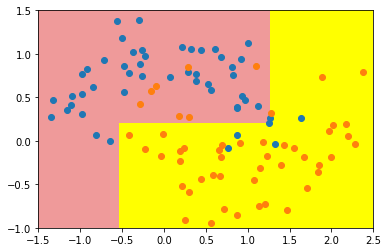

In [4]:
dt_clf2 = DecisionTreeClassifier(max_depth=2)
dt_clf2.fit(X, y)

plot_decision_boundary(dt_clf2, axis=[-1.5, 2.5, -1.0, 1.5])
plt.scatter(X[y==0, 0], X[y==0, 1])
plt.scatter(X[y==1, 0], X[y==1, 1])
plt.show()

明显过拟合有所改善，除此之外，还有很多其他限制方法可以避免决策树过拟合：

* `min_samples_split=10`：每个节点至少有10个数据时才会继续拆分下去
* `min_samples_leaf=6`：每个叶子节点至少要有6个样本数据
* `max_leaf_nodes=4`：决策树的最大叶子节点个数为4
* 其他参数参考 [DecisionTreeClassifier 文档](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier)

上面的剪枝策略简单粗暴，但是在很多任务中非常有效，而且训练速度也非常快。不过也由于其简单性，在处理复杂的决策树时可能得到的泛化性能不是很高，可以引入评估泛化性能的方法，在生成决策树的过程中或生成决策树之后评估剪枝是否能提升泛化性能，从而决定是否剪枝，一般分为 **预剪枝**（prepruning）和 **后剪枝**（postpruning）。

### 预剪枝

预剪枝是指在决策树生成过程中，对每一个节点在划分前先进行估计，若当前节点的划分不能带来泛化性能的提升，则停止划分，并将当前节点标记为叶节点。

如何判定决策树的泛化性能是否提升呢？通常将数据集划分为训练集和验证集两部分，使用训练集训练数据，使用验证集进行性能评估。

预剪枝本质上是一种贪心算法，可以禁止很多分支展开，不仅降低了过拟合的风险，而且减少了决策树训练时间开销和测试时间开销；不过，它有可能会欠拟合。

### 后剪枝

后剪枝是指先从训练集生成一颗完整的决策树，然后**自底向上**的对非叶节点进行考察，若将该节点对应的子树替换为叶节点能提升决策树的泛化性能，则将该子树替换为叶节点。

一般情况下，后剪枝欠拟合的风险很小，泛化性能优于预剪枝；但后剪枝过程是在生成一颗完整的决策树之后进行的，而且要自底向上对树中所有非叶节点进行考察，因此训练时间开销要大得多。

### 参考

1. 周志华.《机器学习》
2. http://www.devtalking.com/articles/machine-learning-16/